In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import json

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve


In [11]:
data_path = 'data/movies'
metadata = pd.read_csv(os.path.join(data_path, 'movies_metadata.csv'), low_memory=False)

def convert_metadata(metadata):
    metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')
    metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
    metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')
    metadata['runtime'] = pd.to_numeric(metadata['runtime'], errors='coerce')
    return metadata

metadata = convert_metadata(metadata)

metadata = metadata[pd.notnull(metadata['title'])]
metadata = metadata[pd.notnull(metadata['budget'])]
metadata = metadata[pd.notnull(metadata['revenue'])]
metadata = metadata[pd.notnull(metadata['runtime'])]
metadata = metadata[pd.notnull(metadata['release_date'])]
metadata = metadata[pd.notnull(metadata['overview'])]

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')
metadata['genre_list'] = metadata['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44435 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  44435 non-null  object        
 1   belongs_to_collection  4429 non-null   object        
 2   budget                 44435 non-null  float64       
 3   genres                 44435 non-null  object        
 4   homepage               7749 non-null   object        
 5   id                     44435 non-null  object        
 6   imdb_id                44423 non-null  object        
 7   original_language      44425 non-null  object        
 8   original_title         44435 non-null  object        
 9   overview               44435 non-null  object        
 10  popularity             44435 non-null  object        
 11  poster_path            44128 non-null  object        
 12  production_companies   44435 non-null  object        
 13  p

In [12]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(metadata['genre_list'])
label_classes = mlb.classes_

label_classes
label_list = []
for elem in label_classes:
  label_list.append(elem)

final_genres = MultiLabelBinarizer(classes = label_list) 
y = final_genres.fit_transform(metadata['genre_list'])
final_genres.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [13]:
X = metadata['title']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True)

X_train_vector = vectorizer.fit_transform(X_train)
X_val_vector = vectorizer.transform(X_val)

(35548,) (8887,) (35548, 20) (8887, 20)


In [14]:
def pipeline(model, params = None, cv = 5):
    if params == None:
        model.fit(X_train_vector, y_train)
        return(model, model.predict(X_train_vector), model.predict(X_val_vector))
    else:
        model_cv = GridSearchCV(estimator = model, param_grid = params, cv = cv)
        model_cv.fit(X_train_vector, y_train)
        model = model_cv.best_estimator_
            
        return(model, model.predict(X_train_vector), model.predict(X_val_vector), model_cv)

In [15]:
mlp = MLPClassifier(verbose = True, max_iter = 10, early_stopping=True, warm_start=True)

model, train_preds, val_preds = pipeline(mlp)

Iteration 1, loss = 9.02501928
Validation score: 0.045851
Iteration 2, loss = 5.64606385
Validation score: 0.053727
Iteration 3, loss = 5.34720580
Validation score: 0.075105
Iteration 4, loss = 4.96626808
Validation score: 0.096484
Iteration 5, loss = 4.56087158
Validation score: 0.107173
Iteration 6, loss = 4.18135745
Validation score: 0.110830
Iteration 7, loss = 3.84597236
Validation score: 0.117018
Iteration 8, loss = 3.55564002
Validation score: 0.118425
Iteration 9, loss = 3.30854933
Validation score: 0.119269
Iteration 10, loss = 3.09663833
Validation score: 0.121519


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
target_names = label_list
training_report = classification_report(y_true=y_train, y_pred=train_preds, target_names=target_names)
validation_report = classification_report(y_true=y_val, y_pred=val_preds, target_names=target_names)
train_accuracy = accuracy_score(y_true=y_train, y_pred=train_preds)
validation_accuracy = accuracy_score(y_true=y_val, y_pred=val_preds)
print("Classification Report - Training:\n", training_report)
print("\nClassification Report - Validation:\n", validation_report)
print("\nAccuracy - Training:", train_accuracy)
print("Accuracy - Validation:", validation_accuracy)

Classification Report - Training:
                  precision    recall  f1-score   support

         Action       0.85      0.58      0.69      5260
      Adventure       0.87      0.40      0.55      2781
      Animation       0.90      0.44      0.59      1530
         Comedy       0.84      0.66      0.74     10254
          Crime       0.86      0.35      0.50      3432
    Documentary       0.91      0.51      0.66      3087
          Drama       0.81      0.75      0.78     15994
         Family       0.88      0.47      0.61      2216
        Fantasy       0.89      0.20      0.33      1850
        Foreign       0.98      0.04      0.08      1311
        History       0.96      0.12      0.21      1090
         Horror       0.86      0.64      0.73      3741
          Music       0.92      0.16      0.27      1274
        Mystery       0.88      0.21      0.33      1975
        Romance       0.83      0.47      0.60      5287
Science Fiction       0.92      0.49      0.64      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

In [17]:

def predict_genre_probabilities_with_names(title, vectorizer, model, label_classes):
    title_vector = vectorizer.transform([title])
    
    genre_probabilities = model.predict_proba(title_vector)
    
    genre_probabilities_with_names = {label: prob for label, prob in zip(label_classes, genre_probabilities[0])}
    
    sorted_probabilities = sorted(genre_probabilities_with_names.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_probabilities

input_title = "The Haunting of the Hill"
probabilities_sorted = predict_genre_probabilities_with_names(input_title, vectorizer, model, label_classes)

for genre, probability in probabilities_sorted:
    print(f"{genre}: {probability}")

Horror: 0.9029885058163233
Thriller: 0.571881985431521
Mystery: 0.22430871187537163
Comedy: 0.1125292054917907
Fantasy: 0.11077516350921016
Action: 0.07169325026189863
Science Fiction: 0.07119048775788317
Drama: 0.04366925152138815
Crime: 0.03702457901197454
Adventure: 0.03550380357567265
Animation: 0.034536590771236816
Documentary: 0.029034880773497647
Family: 0.023488625218175314
TV Movie: 0.017337078015282465
Foreign: 0.01657687254979683
Romance: 0.016516628278098553
Western: 0.012960378324234698
War: 0.005270754858171395
Music: 0.004964234229086422
History: 0.003571703273042603


Text(0, 0.5, 'Accuracy')

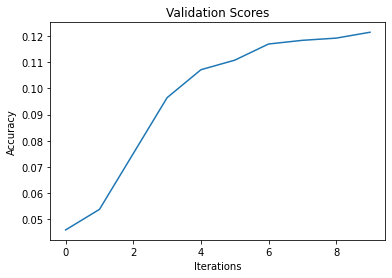

In [20]:
plt.plot(model.validation_scores_)
plt.title('Validation Scores')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Loss')

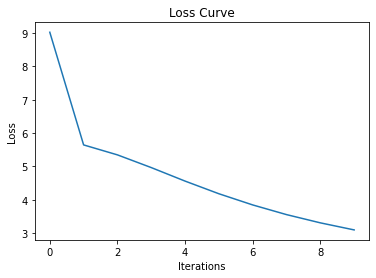

In [21]:
plt.plot(model.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')

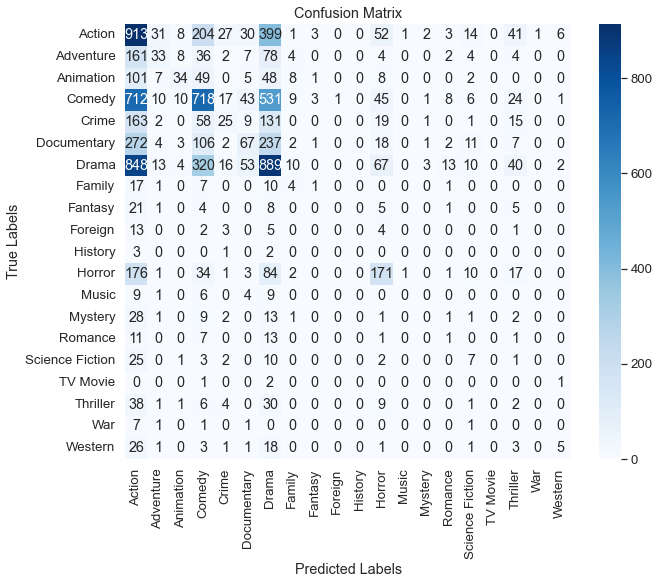

In [27]:
val_preds = model.predict(X_val_vector)

genre_labels = final_genres.classes_

conf_matrix = confusion_matrix(y_val.argmax(axis=1), val_preds.argmax(axis=1))

conf_matrix_df = pd.DataFrame(conf_matrix, index=genre_labels, columns=genre_labels)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix.png')
plt.show()


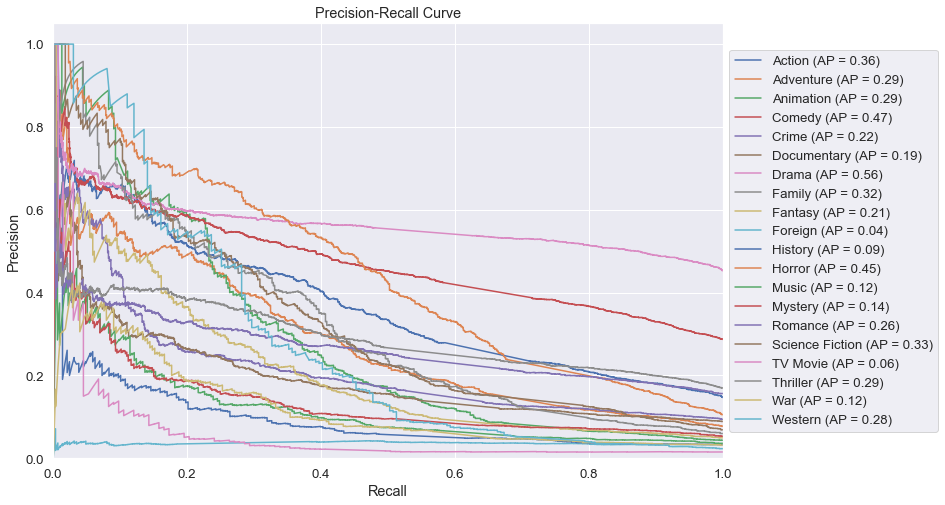

In [32]:
val_preds_proba = model.predict_proba(X_val_vector)

precisions = dict()
recalls = dict()
average_precisions = dict()

for i in range(len(label_list)):
    precisions[i], recalls[i], _ = precision_recall_curve(y_val[:, i], val_preds_proba[:, i])
    average_precisions[i] = average_precision_score(y_val[:, i], val_preds_proba[:, i])

plt.figure(figsize=(12, 8))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')

for i in range(len(label_list)):
    plt.plot(recalls[i], precisions[i], label=f"{label_list[i]} (AP = {average_precisions[i]:0.2f})")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('precision_recall_multiclass.png', bbox_inches='tight')
plt.show()


Iteration 1, loss = 13.73076644
Validation score: 0.000000
Iteration 2, loss = 13.26794479
Validation score: 0.000000
Iteration 3, loss = 12.50791484
Validation score: 0.010526
Iteration 4, loss = 11.43111798
Validation score: 0.038596
Iteration 5, loss = 10.12705530
Validation score: 0.038596
Iteration 6, loss = 8.78283315
Validation score: 0.038596
Iteration 7, loss = 7.60665655
Validation score: 0.038596
Iteration 8, loss = 6.73892819
Validation score: 0.038596
Iteration 9, loss = 6.18401741
Validation score: 0.038596
Iteration 10, loss = 5.85185672
Validation score: 0.038596


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 12.94572448
Validation score: 0.006486
Iteration 2, loss = 9.91728878
Validation score: 0.048649
Iteration 3, loss = 6.78310342
Validation score: 0.048649
Iteration 4, loss = 5.78672147
Validation score: 0.048649
Iteration 5, loss = 5.52771379
Validation score: 0.048649
Iteration 6, loss = 5.36783491
Validation score: 0.057297
Iteration 7, loss = 5.20768699
Validation score: 0.058378
Iteration 8, loss = 5.01921912
Validation score: 0.065946
Iteration 9, loss = 4.80278742
Validation score: 0.073514
Iteration 10, loss = 4.56793586
Validation score: 0.068108


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 12.35243722
Validation score: 0.037724
Iteration 2, loss = 7.05183818
Validation score: 0.037724
Iteration 3, loss = 5.67959015
Validation score: 0.037724
Iteration 4, loss = 5.47013379
Validation score: 0.043478
Iteration 5, loss = 5.27459208
Validation score: 0.058184
Iteration 6, loss = 5.03975243
Validation score: 0.063939
Iteration 7, loss = 4.77701296
Validation score: 0.072251
Iteration 8, loss = 4.50069878
Validation score: 0.073529
Iteration 9, loss = 4.21970849
Validation score: 0.081202
Iteration 10, loss = 3.94168129
Validation score: 0.082481


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 10.54780812
Validation score: 0.052632
Iteration 2, loss = 5.91143374
Validation score: 0.052632
Iteration 3, loss = 5.52304228
Validation score: 0.057169
Iteration 4, loss = 5.29481008
Validation score: 0.072142
Iteration 5, loss = 5.00280839
Validation score: 0.081670
Iteration 6, loss = 4.66410391
Validation score: 0.097096
Iteration 7, loss = 4.31928146
Validation score: 0.103448
Iteration 8, loss = 3.99540214
Validation score: 0.105263
Iteration 9, loss = 3.69916479
Validation score: 0.107532
Iteration 10, loss = 3.43610565
Validation score: 0.111162


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 10.07574314
Validation score: 0.048172
Iteration 2, loss = 5.76927982
Validation score: 0.048172
Iteration 3, loss = 5.49189766
Validation score: 0.055907
Iteration 4, loss = 5.21245157
Validation score: 0.070323
Iteration 5, loss = 4.84088962
Validation score: 0.094937
Iteration 6, loss = 4.46206696
Validation score: 0.102672
Iteration 7, loss = 4.11421067
Validation score: 0.108298
Iteration 8, loss = 3.80497127
Validation score: 0.109001
Iteration 9, loss = 3.53431064
Validation score: 0.108298
Iteration 10, loss = 3.29803766
Validation score: 0.112166


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.99200736
Validation score: 0.000000
Iteration 2, loss = 13.49060203
Validation score: 0.000000
Iteration 3, loss = 12.68459244
Validation score: 0.007018
Iteration 4, loss = 11.55386291
Validation score: 0.042105
Iteration 5, loss = 10.18880802
Validation score: 0.042105
Iteration 6, loss = 8.78628285
Validation score: 0.042105
Iteration 7, loss = 7.57921097
Validation score: 0.042105
Iteration 8, loss = 6.70402688
Validation score: 0.042105
Iteration 9, loss = 6.14639350
Validation score: 0.042105
Iteration 10, loss = 5.81004642
Validation score: 0.042105


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.09449472
Validation score: 0.054054
Iteration 2, loss = 9.90743079
Validation score: 0.054054
Iteration 3, loss = 6.80862991
Validation score: 0.054054
Iteration 4, loss = 5.83111249
Validation score: 0.054054
Iteration 5, loss = 5.57295454
Validation score: 0.054054
Iteration 6, loss = 5.41121597
Validation score: 0.055135
Iteration 7, loss = 5.25138762
Validation score: 0.056216
Iteration 8, loss = 5.06652587
Validation score: 0.060541
Iteration 9, loss = 4.85466203
Validation score: 0.070270
Iteration 10, loss = 4.62300895
Validation score: 0.084324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 12.47942771
Validation score: 0.051151
Iteration 2, loss = 7.26823611
Validation score: 0.051151
Iteration 3, loss = 5.76472516
Validation score: 0.051151
Iteration 4, loss = 5.52874300
Validation score: 0.049872
Iteration 5, loss = 5.34064877
Validation score: 0.054987
Iteration 6, loss = 5.10354304
Validation score: 0.069054
Iteration 7, loss = 4.82328602
Validation score: 0.074169
Iteration 8, loss = 4.52255382
Validation score: 0.079923
Iteration 9, loss = 4.22214536
Validation score: 0.085038
Iteration 10, loss = 3.93787990
Validation score: 0.088875


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 10.97557124
Validation score: 0.049456
Iteration 2, loss = 6.10340628
Validation score: 0.049456
Iteration 3, loss = 5.58211439
Validation score: 0.050363
Iteration 4, loss = 5.33910472
Validation score: 0.074410
Iteration 5, loss = 5.02389282
Validation score: 0.085299
Iteration 6, loss = 4.66827671
Validation score: 0.093920
Iteration 7, loss = 4.32247371
Validation score: 0.105263
Iteration 8, loss = 4.00344181
Validation score: 0.107985
Iteration 9, loss = 3.71640177
Validation score: 0.106171
Iteration 10, loss = 3.45625173
Validation score: 0.107985


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 10.30935269
Validation score: 0.046765
Iteration 2, loss = 5.79559542
Validation score: 0.048172
Iteration 3, loss = 5.46502343
Validation score: 0.061885
Iteration 4, loss = 5.14353610
Validation score: 0.082630
Iteration 5, loss = 4.77964389
Validation score: 0.089662
Iteration 6, loss = 4.41086215
Validation score: 0.090717
Iteration 7, loss = 4.06645928
Validation score: 0.095288
Iteration 8, loss = 3.75556899
Validation score: 0.096343
Iteration 9, loss = 3.48191793
Validation score: 0.097750
Iteration 10, loss = 3.23901759
Validation score: 0.111463


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.86663527
Validation score: 0.000000
Iteration 2, loss = 13.37144820
Validation score: 0.000000
Iteration 3, loss = 12.55940171
Validation score: 0.042105
Iteration 4, loss = 11.39586756
Validation score: 0.045614
Iteration 5, loss = 9.98404857
Validation score: 0.045614
Iteration 6, loss = 8.55061506
Validation score: 0.045614
Iteration 7, loss = 7.34640616
Validation score: 0.045614
Iteration 8, loss = 6.52393689
Validation score: 0.045614
Iteration 9, loss = 6.03261502
Validation score: 0.045614
Iteration 10, loss = 5.74720567
Validation score: 0.049123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.19225514
Validation score: 0.054054
Iteration 2, loss = 9.83559316
Validation score: 0.054054
Iteration 3, loss = 6.83835091
Validation score: 0.054054
Iteration 4, loss = 5.89663113
Validation score: 0.054054
Iteration 5, loss = 5.63172133
Validation score: 0.054054
Iteration 6, loss = 5.48213789
Validation score: 0.055135
Iteration 7, loss = 5.34132481
Validation score: 0.057297
Iteration 8, loss = 5.17975695
Validation score: 0.065946
Iteration 9, loss = 4.99771845
Validation score: 0.080000
Iteration 10, loss = 4.79716192
Validation score: 0.089730


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.83427264
Validation score: 0.057545
Iteration 2, loss = 7.01055625
Validation score: 0.057545
Iteration 3, loss = 5.71235861
Validation score: 0.058184
Iteration 4, loss = 5.48476366
Validation score: 0.072890
Iteration 5, loss = 5.29124713
Validation score: 0.084399
Iteration 6, loss = 5.04682010
Validation score: 0.085678
Iteration 7, loss = 4.75978629
Validation score: 0.096547
Iteration 8, loss = 4.45924140
Validation score: 0.102302
Iteration 9, loss = 4.15981211
Validation score: 0.113171
Iteration 10, loss = 3.87367567
Validation score: 0.108696


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.43222493
Validation score: 0.050363
Iteration 2, loss = 6.09764551
Validation score: 0.050363
Iteration 3, loss = 5.57222478
Validation score: 0.051724
Iteration 4, loss = 5.37172128
Validation score: 0.066243
Iteration 5, loss = 5.11176193
Validation score: 0.076679
Iteration 6, loss = 4.79652476
Validation score: 0.085753
Iteration 7, loss = 4.46734369
Validation score: 0.093920
Iteration 8, loss = 4.14475856
Validation score: 0.099365
Iteration 9, loss = 3.84437906
Validation score: 0.101633
Iteration 10, loss = 3.56750347
Validation score: 0.107532


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 9.69485460
Validation score: 0.053797
Iteration 2, loss = 5.76628892
Validation score: 0.054149
Iteration 3, loss = 5.47515814
Validation score: 0.065049
Iteration 4, loss = 5.17438222
Validation score: 0.084740
Iteration 5, loss = 4.81106687
Validation score: 0.096695
Iteration 6, loss = 4.43617652
Validation score: 0.103024
Iteration 7, loss = 4.08670943
Validation score: 0.104782
Iteration 8, loss = 3.77343955
Validation score: 0.109705
Iteration 9, loss = 3.49652334
Validation score: 0.112518
Iteration 10, loss = 3.25502917
Validation score: 0.110759


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.53269073
Validation score: 0.000000
Iteration 2, loss = 13.12777638
Validation score: 0.000000
Iteration 3, loss = 12.44408261
Validation score: 0.017544
Iteration 4, loss = 11.42259466
Validation score: 0.119298
Iteration 5, loss = 10.12464027
Validation score: 0.059649
Iteration 6, loss = 8.74479401
Validation score: 0.059649
Iteration 7, loss = 7.53733444
Validation score: 0.059649
Iteration 8, loss = 6.66783831
Validation score: 0.059649
Iteration 9, loss = 6.12490877
Validation score: 0.059649
Iteration 10, loss = 5.79491039
Validation score: 0.059649


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.13820063
Validation score: 0.042162
Iteration 2, loss = 9.92066128
Validation score: 0.045405
Iteration 3, loss = 6.81017722
Validation score: 0.045405
Iteration 4, loss = 5.83935186
Validation score: 0.045405
Iteration 5, loss = 5.57968875
Validation score: 0.046486
Iteration 6, loss = 5.42318588
Validation score: 0.048649
Iteration 7, loss = 5.27304632
Validation score: 0.051892
Iteration 8, loss = 5.10305655
Validation score: 0.063784
Iteration 9, loss = 4.90751355
Validation score: 0.059459
Iteration 10, loss = 4.69008430
Validation score: 0.071351


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.73364576
Validation score: 0.048593
Iteration 2, loss = 6.89987947
Validation score: 0.048593
Iteration 3, loss = 5.71760984
Validation score: 0.048593
Iteration 4, loss = 5.47642626
Validation score: 0.053069
Iteration 5, loss = 5.23470887
Validation score: 0.071611
Iteration 6, loss = 4.94091866
Validation score: 0.080563
Iteration 7, loss = 4.62591627
Validation score: 0.086317
Iteration 8, loss = 4.31636478
Validation score: 0.092711
Iteration 9, loss = 4.02762202
Validation score: 0.095908
Iteration 10, loss = 3.76289977
Validation score: 0.093350


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.22134229
Validation score: 0.044465
Iteration 2, loss = 6.03962802
Validation score: 0.044465
Iteration 3, loss = 5.55819334
Validation score: 0.055808
Iteration 4, loss = 5.32239918
Validation score: 0.063521
Iteration 5, loss = 5.00469083
Validation score: 0.078947
Iteration 6, loss = 4.65425093
Validation score: 0.089383
Iteration 7, loss = 4.31178523
Validation score: 0.093466
Iteration 8, loss = 3.99459615
Validation score: 0.097096
Iteration 9, loss = 3.70659259
Validation score: 0.098004
Iteration 10, loss = 3.45210396
Validation score: 0.099819


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 10.25478058
Validation score: 0.044655
Iteration 2, loss = 5.78477007
Validation score: 0.044655
Iteration 3, loss = 5.47425782
Validation score: 0.061533
Iteration 4, loss = 5.16783475
Validation score: 0.077004
Iteration 5, loss = 4.80204264
Validation score: 0.097046
Iteration 6, loss = 4.43971604
Validation score: 0.104079
Iteration 7, loss = 4.09985449
Validation score: 0.106892
Iteration 8, loss = 3.78858999
Validation score: 0.108298
Iteration 9, loss = 3.50628727
Validation score: 0.109705
Iteration 10, loss = 3.25629501
Validation score: 0.109353


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 13.55174343
Validation score: 0.000000
Iteration 2, loss = 13.04759227
Validation score: 0.000000
Iteration 3, loss = 12.23754767
Validation score: 0.038596
Iteration 4, loss = 11.08964264
Validation score: 0.038596
Iteration 5, loss = 9.72435179
Validation score: 0.038596
Iteration 6, loss = 8.35933558
Validation score: 0.038596
Iteration 7, loss = 7.24368901
Validation score: 0.038596
Iteration 8, loss = 6.47273998
Validation score: 0.038596
Iteration 9, loss = 6.01155825
Validation score: 0.038596
Iteration 10, loss = 5.73859851
Validation score: 0.038596


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 12.73273031
Validation score: 0.057297
Iteration 2, loss = 9.87568669
Validation score: 0.057297
Iteration 3, loss = 6.89819721
Validation score: 0.057297
Iteration 4, loss = 5.83584897
Validation score: 0.057297
Iteration 5, loss = 5.55732699
Validation score: 0.057297
Iteration 6, loss = 5.38306270
Validation score: 0.065946
Iteration 7, loss = 5.19973090
Validation score: 0.076757
Iteration 8, loss = 4.99399823
Validation score: 0.087568
Iteration 9, loss = 4.76912375
Validation score: 0.087568
Iteration 10, loss = 4.52745454
Validation score: 0.094054


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 12.34458118
Validation score: 0.049233
Iteration 2, loss = 7.26667611
Validation score: 0.049233
Iteration 3, loss = 5.73053305
Validation score: 0.049233
Iteration 4, loss = 5.47926218
Validation score: 0.048593
Iteration 5, loss = 5.26419588
Validation score: 0.058184
Iteration 6, loss = 5.00011254
Validation score: 0.072890
Iteration 7, loss = 4.70761321
Validation score: 0.083120
Iteration 8, loss = 4.40674163
Validation score: 0.091432
Iteration 9, loss = 4.10636871
Validation score: 0.091432
Iteration 10, loss = 3.81857276
Validation score: 0.092711


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.10556128
Validation score: 0.049002
Iteration 2, loss = 6.18385246
Validation score: 0.049002
Iteration 3, loss = 5.59577199
Validation score: 0.051724
Iteration 4, loss = 5.35958148
Validation score: 0.058076
Iteration 5, loss = 5.03318555
Validation score: 0.082123
Iteration 6, loss = 4.67195433
Validation score: 0.092105
Iteration 7, loss = 4.31782792
Validation score: 0.099365
Iteration 8, loss = 3.98800953
Validation score: 0.105263
Iteration 9, loss = 3.68959686
Validation score: 0.111615
Iteration 10, loss = 3.42159079
Validation score: 0.115699


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 10.00823195
Validation score: 0.052039
Iteration 2, loss = 5.76041806
Validation score: 0.052039
Iteration 3, loss = 5.48447939
Validation score: 0.058368
Iteration 4, loss = 5.21942972
Validation score: 0.074543
Iteration 5, loss = 4.87761023
Validation score: 0.089662
Iteration 6, loss = 4.49091019
Validation score: 0.100914
Iteration 7, loss = 4.12262814
Validation score: 0.105134
Iteration 8, loss = 3.79667446
Validation score: 0.107243
Iteration 9, loss = 3.51542523
Validation score: 0.104430
Iteration 10, loss = 3.27206228
Validation score: 0.106188


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


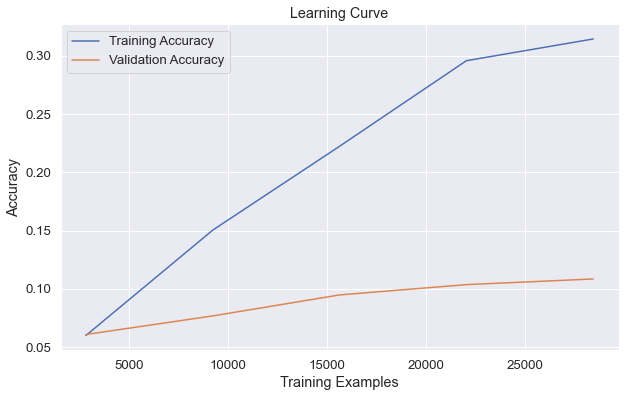

In [29]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_vector, y_train, cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.savefig('learning_curve.png')
plt.show()